In [1]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
from sklearn import preprocessing
import numpy as np
import IPython


In [2]:
from math import floor
path_train = 'data/train_labels.csv'
path_test = 'data/test_files.csv'
num_cc = 100
df = pd.read_csv(path_train)
total_count = len(df.index)
df['filename'] = df['filename'].map(lambda x: 'data/data/%04d.wav' % x)
print(total_count)
df.head(2)

1532


,filename,pasture,height,label
0,data/data/0004.wav,alfalfa,tall,2
1,data/data/0009.wav,alfalfa,tall,2


In [606]:
IPython.display.Audio(df.loc[4]['filename'])

In [3]:
def extract_features(file_name):
    data, sample_rate = librosa.load(file_name, res_type='scipy', sr=2000)
    #mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_cc), axis=0)
    data = librosa.feature.mfcc(y=data,n_mfcc=num_cc)
    data = librosa.util.normalize(data)
    return data

In [4]:

features = []
for k,row in df.iterrows():
    class_label = row["label"]
    data = extract_features(row['filename'])
    features.append([data, class_label])
df_features = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from ', len(df_features), ' files')
df_features.head(2)

Finished feature extraction from  1532  files


,feature,class_label
0,"[[-1.0, -0.5786434, -0.4634809, -1.0], [0.3236...",2
1,"[[-1.0, -1.0, -0.8465223, -1.0], [0.16447794, ...",2


array([2, 2, 1, ..., 1, 1, 0])

In [40]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(df_features.feature.tolist())
Y = np.array(df_features.class_label.tolist())
# Encode the classification labels
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
#X.shape
#from sklearn.preprocessing import MultiLabelBinarizer
#y = MultiLabelBinarizer().fit_transform(Y)


In [41]:
y.shape

(1532, 3)

In [42]:
def build_model():
    global X
#    global y
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
    from keras.optimizers import Adam
    from sklearn import metrics
    import keras
#    num_labels = y.shape[1]

    model = Sequential()


    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X.shape[1],X.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(filters=64,kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model


In [57]:
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 200

es = EarlyStopping(monitor='val_loss', patience=150)
ch = ModelCheckpoint(filepath='data/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)


callbacks = [es, ch, LivePlot()]

dummy_y = np_utils.to_categorical(Y)
#, callbacks=[callbacks]
estimator = KerasClassifier(build_fn=build_model, epochs=3, batch_size=200, verbose=1)
kfold = KFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/3
766/766 [==============================] - 1s 1ms/step - loss: 1.0870 - accuracy: 0.4621
Epoch 2/3
766/766 [==============================] - 0s 400us/step - loss: 1.0369 - accuracy: 0.5535
Epoch 3/3
766/766 [==============================] - 0s 295us/step
Epoch 1/3
766/766 [==============================] - 1s 2ms/step - loss: 1.0814 - accuracy: 0.4073
Epoch 2/3
766/766 [==============================] - 0s 432us/step - loss: 1.0359 - accuracy: 0.5287
Epoch 3/3
766/766 [==============================] - 0s 300us/step
Baseline: 53.98% (1.37%)


In [50]:
import keras
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

class LivePlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()


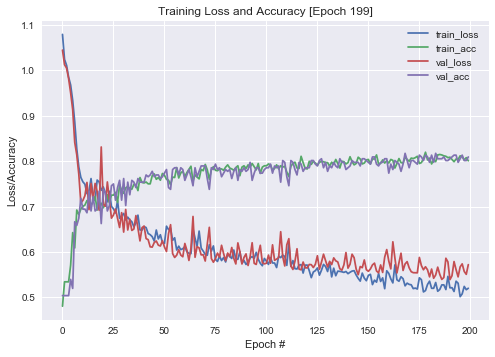

Training completed in time:  0:01:18.137715


In [618]:
#https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 200

es = EarlyStopping(monitor='val_loss', patience=150)
ch = ModelCheckpoint(filepath='data/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)


callbacks = [es, ch, LivePlot()]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test, y_test), 
          verbose=1,
          callbacks=callbacks)


duration = datetime.now() - start
print("Training completed in time: ", duration)


In [619]:
path_weights = 'data/weights.best.basic_cnn.hdf5'
model.load_weights(path_weights)

# Evaluating the model on the training and testing set
score_t = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_t[1])

score_v = model.evaluate(x_test, y_test, verbose=0)
print("Val Accuracy: ", score_v[1])


features = []
for k,row in df_test_my.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')
X_test_my = np.array(df_features_test.feature.tolist())
le = LabelEncoder()
y_test_my = df_test_my.label.tolist()
Y_test_my = to_categorical(le.fit_transform(y_test_my)) 

#X_test_my = np.expand_dims(X_test_my, axis=2)

# Evaluating the model on the training and testing set
score_test = model.evaluate(X_test_my, Y_test_my, verbose=0)
print("Test Accuracy: ", score_test[1])


Training Accuracy:  0.8228855723172278
Val Accuracy:  0.8055555555555556
Finished feature extraction from  275  files
Test Accuracy:  0.8654545454545455


In [58]:
df_test_ = pd.read_csv(path_test)
df_test = df_test_.copy()
df_test['filename'] = df_test['filename'].map(lambda x: 'data/data/%04d.wav' % x)
print(len(df_test.index))
df_test.head(2)

1551


,filename
0,data/data/0001.wav
1,data/data/0002.wav


In [ ]:
features = []
for k,row in df_test.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')


In [622]:
X_test = np.array(df_features_test.feature.tolist())
#X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [623]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)


In [624]:
len(X_test)

1551

In [625]:
y_classes

array([0, 2, 2, ..., 1, 1, 0])

In [626]:
df_test_['label'] = y_classes

In [628]:
from datetime import datetime
now = datetime.now() # current date and time
timestamp = now.strftime("%Y%m%d_%H%M%S")
model_json = model.to_json()
model.save_weights('data/%s_weights.hdf5' % timestamp)
with open("data/%s_model.json" % timestamp, "w") as json_file:
    json_file.write(model_json)
df_test_.to_csv('data/%s_res.csv' % timestamp, index=None, header=None)
with open("data/%s_score.txt" % timestamp, "w") as file:
    scoring = "validation acc: %f - training acc: %f - test acc %f:" % (score_v[1], score_t[1], score_test[1])
    file.write(scoring)

timestamp

'20191107_155744'